In [ ]:
import os
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
seed = 1

In [ ]:
# 경로지정
os.chdir(r'D:\QAE\fall\\머신러닝')

# df
df = pd.read_excel(r'기초데이터.xlsx')

# 데이터 null값 있나 확인 후 있으면 ffil(전일 데이터로 채우기)
null_check = df.isnull().values.any()
print(null_check) # True = > null 값 존재
df.fillna(method='ffill', inplace=True)

# 재확인
null_check = df.isnull().values.any()
print(null_check) # False = > null 값 없음

# 환율 변동 1개월, 3개월, 6개월, 1년 => vix지수와 관련?
# USD_VND : 베트남동, USD_SGD : 싱가폴 달러, USD_CNY : 중국 위안, USD_IDR: 인도네시아루피아
# YEN_DOLLAR : 일본 엔, WON_DOLLAR : 대한민국 원, EURO_USD: 유로

# 일별 변화율 계산
df['USD_VND_daily'] = (df['USD_VND'].shift(0) - df['USD_VND'].shift(1)) / df['USD_VND'].shift(1)
df['USD_SGD_daily'] = (df['USD_SGD'].shift(0) - df['USD_SGD'].shift(1)) / df['USD_SGD'].shift(1)
df['USD_CNY_daily'] = (df['USD_CNY'].shift(0) - df['USD_CNY'].shift(1)) / df['USD_CNY'].shift(1)
df['USD_IDR_daily'] = (df['USD_IDR'].shift(0) - df['USD_IDR'].shift(1)) / df['USD_IDR'].shift(1)
df['YEN_DOLLAR_daily'] = (df['YEN_DOLLAR'].shift(0) - df['YEN_DOLLAR'].shift(1)) / df['YEN_DOLLAR'].shift(1)
df['WON_DOLLAR_daily'] = (df['WON_DOLLAR'].shift(0) - df['WON_DOLLAR'].shift(1)) / df['WON_DOLLAR'].shift(1)
df['EURO_USD_daily'] = (df['EURO_USD'].shift(0) - df['EURO_USD'].shift(1)) / df['EURO_USD'].shift(1)

True
False


In [ ]:
"""
# 각 환율의 1개월, 3개월, 6개월, 1년 변동성 계산하기
ticker = ['USD_VND', 'USD_SGD', 'USD_CNY', 'USD_IDR', 'YEN_DOLLAR', 'WON_DOLLAR', 'EURO_USD']

df = df.dropna().reset_index(drop='index')

for money in ticker:

    print(f'{money}에 대한 계산 처리중...')

    # 월
    df[f'{money}_monthly'] = df[f'{money}_daily'].rolling(30).std()

    # 분기
    df[f'{money}_quarterly'] = df[f'{money}_daily'].rolling(60).std()

    # 반기
    df[f'{money}_halfly'] = df[f'{money}_daily'].rolling(180).std()

    # 연
    df[f'{money}_yearly'] = df[f'{money}_daily'].rolling(360).std()


# 데이터 너무 많음 월, 분기, 반기, 연으로 나누겠음
df_month = df[['날짜', 'VIX', 'USD_VND_monthly', 'USD_SGD_monthly', 'USD_CNY_monthly', 'USD_IDR_monthly', 'YEN_DOLLAR_monthly', 'WON_DOLLAR_monthly', 'EURO_USD_monthly']]
df_quarter = df[['날짜', 'VIX', 'USD_VND_quarterly', 'USD_SGD_quarterly', 'USD_CNY_quarterly', 'USD_IDR_quarterly', 'YEN_DOLLAR_quarterly', 'WON_DOLLAR_quarterly', 'EURO_USD_quarterly']]
df_half = df[['날짜', 'VIX', 'USD_VND_halfly', 'USD_SGD_halfly', 'USD_CNY_halfly', 'USD_IDR_halfly', 'YEN_DOLLAR_halfly', 'WON_DOLLAR_halfly', 'EURO_USD_halfly']]
df_year = df[['날짜', 'VIX', 'USD_VND_yearly', 'USD_SGD_yearly', 'USD_CNY_yearly', 'USD_IDR_yearly', 'YEN_DOLLAR_yearly', 'WON_DOLLAR_yearly', 'EURO_USD_yearly']]

# 월부터
df_month = df_month.dropna().reset_index(drop='index')
df_month.index = df_month['날짜']
df_month.drop(columns='날짜', inplace=True)
"""

"\n# 각 환율의 1개월, 3개월, 6개월, 1년 변동성 계산하기\nticker = ['USD_VND', 'USD_SGD', 'USD_CNY', 'USD_IDR', 'YEN_DOLLAR', 'WON_DOLLAR', 'EURO_USD']\n\ndf = df.dropna().reset_index(drop='index')\n\nfor money in ticker:\n\n    print(f'{money}에 대한 계산 처리중...')\n\n    # 월\n    df[f'{money}_monthly'] = df[f'{money}_daily'].rolling(30).std()\n\n    # 분기\n    df[f'{money}_quarterly'] = df[f'{money}_daily'].rolling(60).std()\n\n    # 반기\n    df[f'{money}_halfly'] = df[f'{money}_daily'].rolling(180).std()\n\n    # 연\n    df[f'{money}_yearly'] = df[f'{money}_daily'].rolling(360).std()\n\n\n# 데이터 너무 많음 월, 분기, 반기, 연으로 나누겠음\ndf_month = df[['날짜', 'VIX', 'USD_VND_monthly', 'USD_SGD_monthly', 'USD_CNY_monthly', 'USD_IDR_monthly', 'YEN_DOLLAR_monthly', 'WON_DOLLAR_monthly', 'EURO_USD_monthly']]\ndf_quarter = df[['날짜', 'VIX', 'USD_VND_quarterly', 'USD_SGD_quarterly', 'USD_CNY_quarterly', 'USD_IDR_quarterly', 'YEN_DOLLAR_quarterly', 'WON_DOLLAR_quarterly', 'EURO_USD_quarterly']]\ndf_half = df[['날짜', 'VIX', 'USD_VND_half

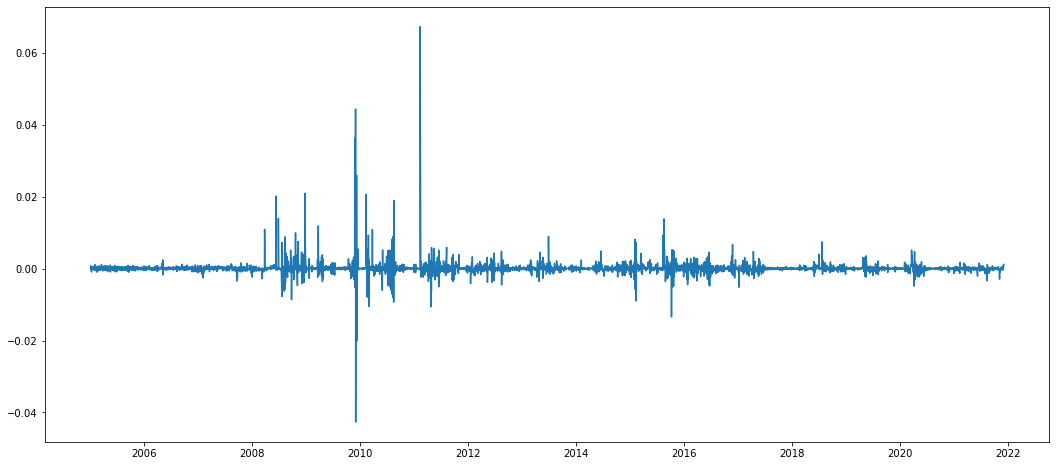

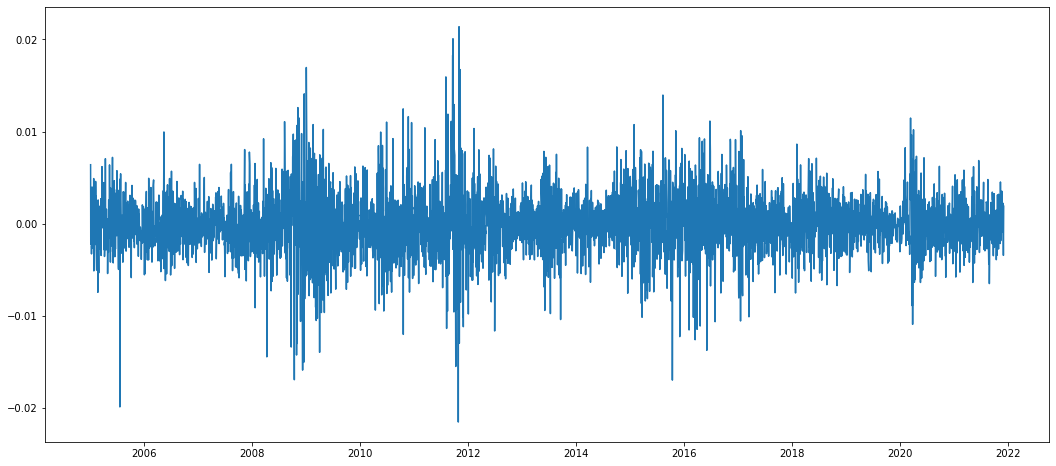

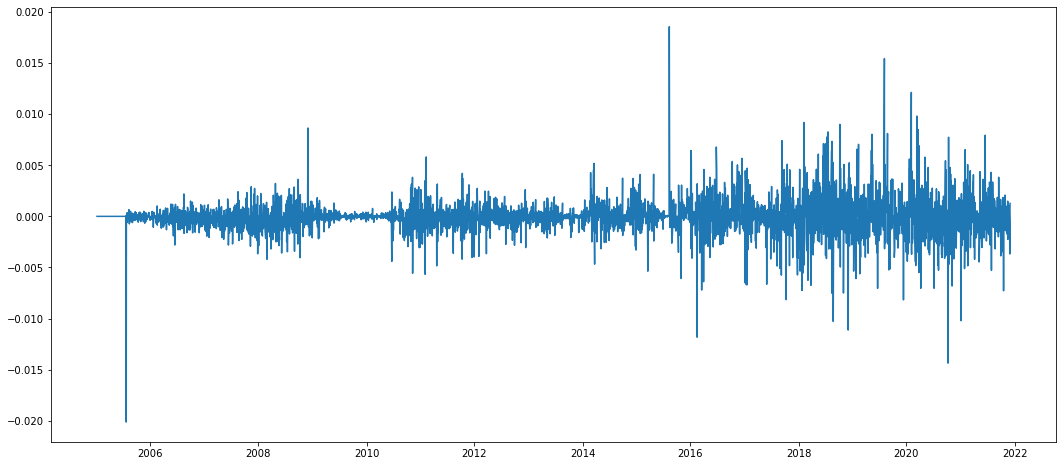

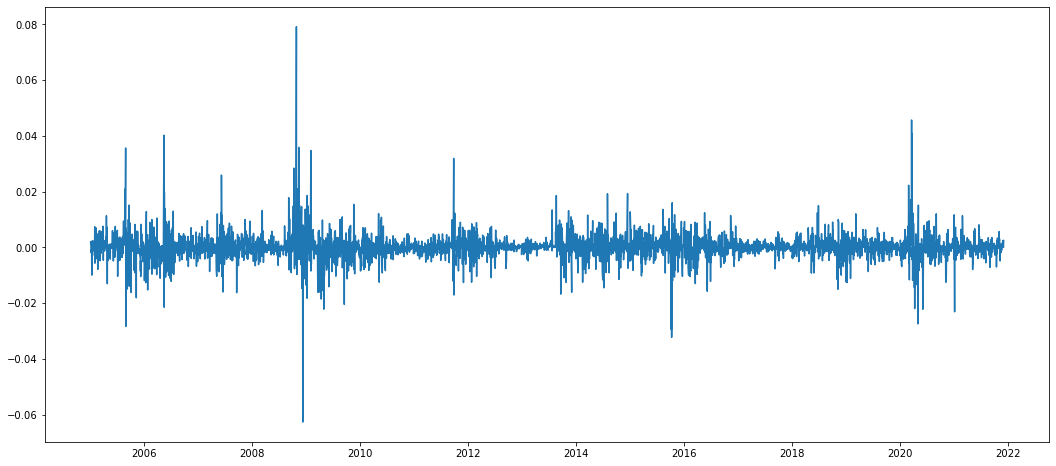

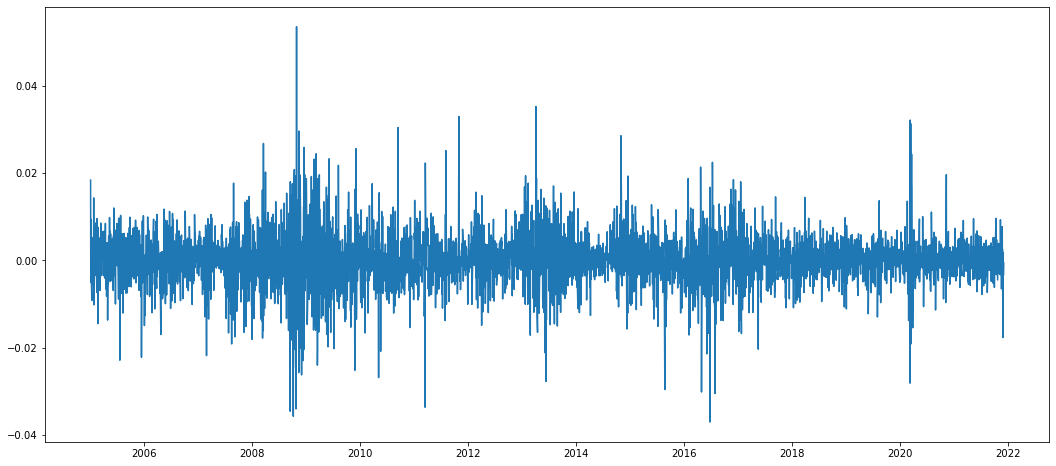

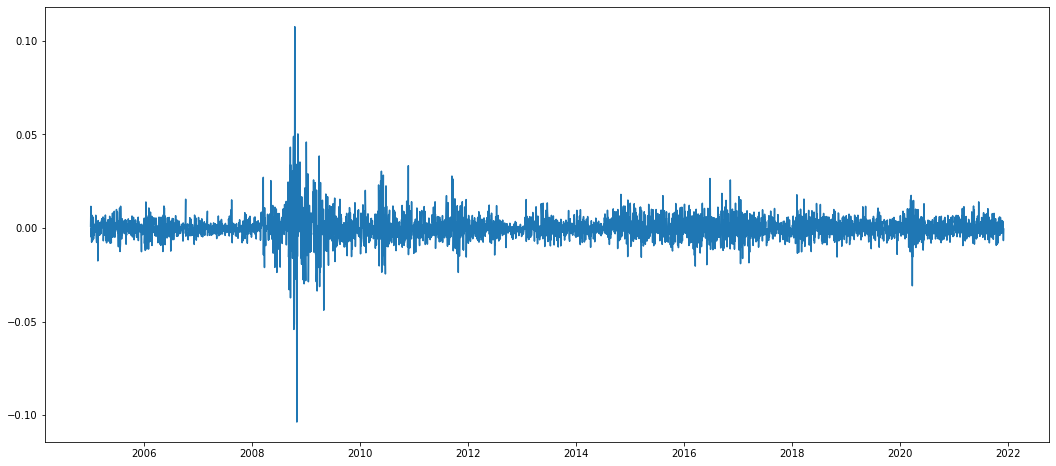

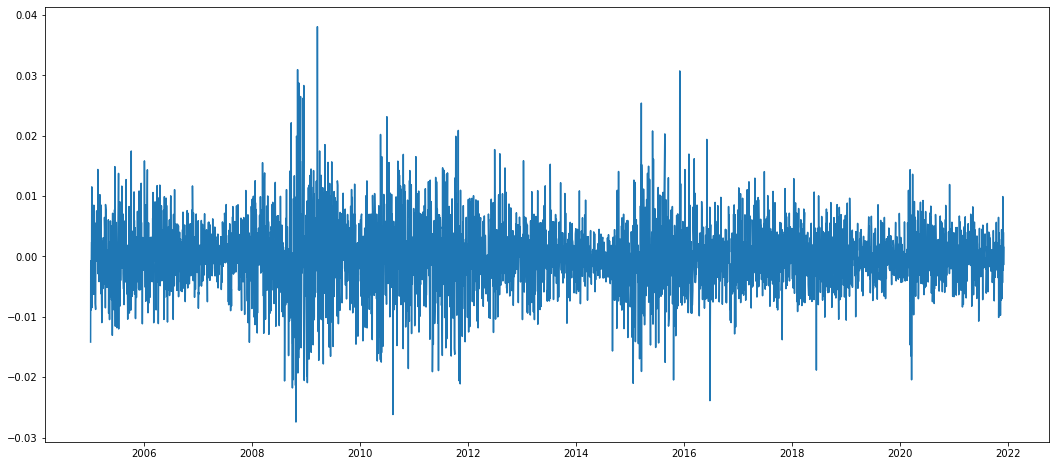

In [ ]:
# 각 환율의 변동성을 그림으로 나타내기 => 걍 변동성 일정하게 움직이는거 확인, 자료로 쓰자
# 베트남 동
plt.figure(figsize=(18,8))
plt.plot(df['날짜'], df['USD_VND_daily'])
plt.show()

#싱가폴달러
plt.figure(figsize=(18,8))
plt.plot(df['날짜'], df['USD_SGD_daily'])
plt.show()

#차이나위안
plt.figure(figsize=(18,8))
plt.plot(df['날짜'], df['USD_CNY_daily'])
plt.show()

#인도네시아 루피아
plt.figure(figsize=(18,8))
plt.plot(df['날짜'], df['USD_IDR_daily'])
plt.show()

#엔달러
plt.figure(figsize=(18,8))
plt.plot(df['날짜'], df['YEN_DOLLAR_daily'])
plt.show()

#원달러
plt.figure(figsize=(18,8))
plt.plot(df['날짜'], df['WON_DOLLAR_daily'])
plt.show()

#유로달러
plt.figure(figsize=(18,8))
plt.plot(df['날짜'], df['EURO_USD_daily'])
plt.show()

ADF Statistics: -20.950091563689575
p-value: 0.0
Critical values:
	1%: .-3.432
	5%: .-2.862
	10%: .-2.567
ADF Statistics: -15.846772960303612
p-value: 9.5513237277819e-29
Critical values:
	1%: .-3.432
	5%: .-2.862
	10%: .-2.567
ADF Statistics: -9.808752684805748
p-value: 5.731794858965518e-17
Critical values:
	1%: .-3.432
	5%: .-2.862
	10%: .-2.567
ADF Statistics: -12.756466003443249
p-value: 8.319007281906417e-24
Critical values:
	1%: .-3.432
	5%: .-2.862
	10%: .-2.567
ADF Statistics: -69.76434581086298
p-value: 0.0
Critical values:
	1%: .-3.432
	5%: .-2.862
	10%: .-2.567
ADF Statistics: -11.528640356193032
p-value: 3.88031290725484e-21
Critical values:
	1%: .-3.432
	5%: .-2.862
	10%: .-2.567
ADF Statistics: -66.25004033144444
p-value: 0.0
Critical values:
	1%: .-3.432
	5%: .-2.862
	10%: .-2.567
USD_VND_daily을 처리중
USD_SGD_daily을 처리중
USD_CNY_daily을 처리중
USD_IDR_daily을 처리중
YEN_DOLLAR_daily을 처리중
WON_DOLLAR_daily을 처리중
EURO_USD_daily을 처리중
['USD_VND_daily', 'USD_SGD_daily', 'USD_CNY_daily', 

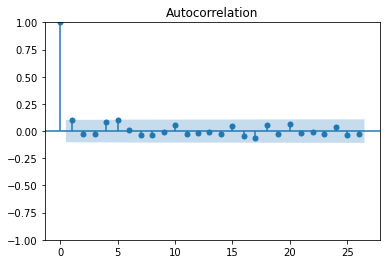

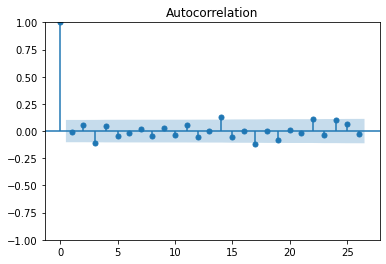

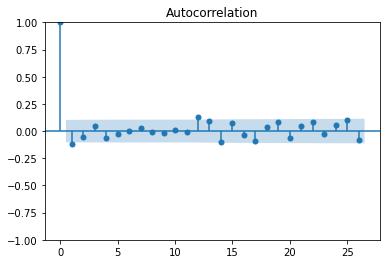

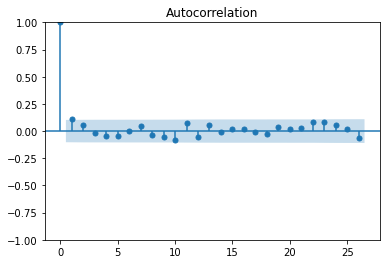

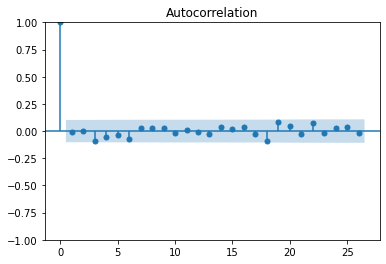

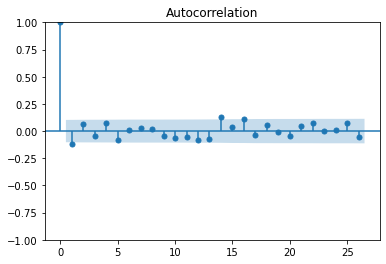

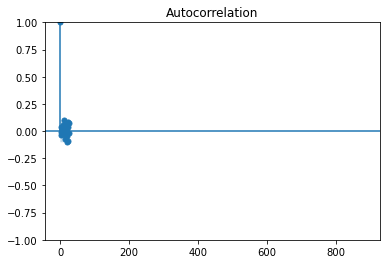

In [ ]:
# autocorrelation 확인, 왜? => 표본의 무작위성(randomness)은 서로 다른 관측치들에 대한 오차항이 상관되어 있지 말아야함을 의미하나, 자기상관은 이런 무작위성이 위배됨.
# 엄청나게 significant한 상관성을 보이지는 않음..., 일부는 상관성 존재 => garch로 변동성 분포 확인
# 베트남 동
plot_acf(df[['USD_VND_daily']].iloc[-365:].values) # 주기모호

# 싱가폴 달러
plot_acf(df[['USD_SGD_daily']].iloc[-365:].values) # 주기모호

# 차이나위안
plot_acf(df[['USD_CNY_daily']].iloc[-365:].values) # 주기가 모호함

# 인도네시아 루피아
plot_acf(df[['USD_IDR_daily']].iloc[-365:].values) # 주기가 모호함

# 엔달러
plot_acf(df[['YEN_DOLLAR_daily']].iloc[-365:].values) # 주기가 모호함

# 원달러
plot_acf(df[['WON_DOLLAR_daily']].iloc[-365:].values) # 주기가 모호함

#유로달러
plot_acf(df[['EURO_USD_daily']].iloc[-365:].values) # 주기 모호함

# data의 stationary test를 위해 ADF 검정  실시해보겠음
# H0: non-stationary, H1: stationary
def adf_test(df):

    result = adfuller(df.values)

    print(f'ADF Statistics: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical values:')
    for key, value in result[4].items():
        print('\t%s: .%.3f' % (key, value))

# 베트남 동
adf_test(df['USD_VND_daily'].iloc[1:]) # stationary

# 싱가폴 달러
adf_test(df['USD_SGD_daily'].iloc[1:]) # stationary

# 차이나위안
adf_test(df['USD_CNY_daily'].iloc[1:]) # stationary

# 인도네시아 루피아
adf_test(df['USD_IDR_daily'].iloc[1:]) # stationary

# 엔달러
adf_test(df['YEN_DOLLAR_daily'].iloc[1:]) # stationary

# 원달러
adf_test(df['WON_DOLLAR_daily'].iloc[1:]) # stationary

#유로달러
adf_test(df['EURO_USD_daily'].iloc[1:])  # stationary

# stationary하고 자기상관성 없는데 굳이 garch 쓸 필요는 없어보임.
# 따라서 모델 해석에 도움이 되기 위해서 Linear model을 사용해서 예측을 진행
# 첫번쨰 training data와 test데이터의 train 80%, test 20%로 나눈후 한 번에 예측을 결정하는 일반적인 방법 => 파라미터 간의 관계 해석을 위해
# 해석적인 영역에서는 분명 도움이 될 것이라고 생각됨.
# 두번째 방식은 lookback 즉 학습기간을 월, 분기, 반기, 연으로 지정해서 그 다음 일을 예측하는 방식을 사용해보겠음

ticker = ['USD_VND_daily', 'USD_SGD_daily', 'USD_CNY_daily', 'USD_IDR_daily', 'YEN_DOLLAR_daily', 'WON_DOLLAR_daily', 'EURO_USD_daily']

for name in ticker:

    print(f'{name}을 처리중')

    df[f'{name}'] = df[f'{name}'].shift(1)

# 첫번째 정석적인 머신러닝 방식을 통한 방법 => cv fold 방식은 시계열 자료이기 때문에 사용하지 않겠음.. => 변수간 관계 파악을 위해 용이하다고 판단됨..
df = df.dropna().reset_index(drop='index')
df.index = df['날짜']
df.drop(columns=['날짜'], inplace=True)

# 어차피 변화율들이기 때문에 log를 사용할 필요는 없어보임..
X_data = df[['USD_VND_daily', 'USD_SGD_daily', 'USD_CNY_daily', 'USD_IDR_daily', 'YEN_DOLLAR_daily', 'WON_DOLLAR_daily', 'EURO_USD_daily']].values
y_data = df[['VIX']].values

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, shuffle=False, random_state=seed)

# train
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# prediction
vix_pred = linear_model.predict(X_test)

# coefficients, ticker 순서대로 coef임..
print(ticker)
print("Coefficients: \n", linear_model.coef_)

# Mean Squared Error
print("Mean squared error: %.2f" % mean_squared_error(y_test, vix_pred))

# r2_score
print("Coefficient of determination: %.2f" % r2_score(y_test, vix_pred))

plt.plot(y_test)
plt.plot(vix_pred)
# 제대로된 예측을 할 수 없음이 보임..

In [ ]:
# 그래서 lookback기간 즉 데이터 학습 기간을 30일로 놓고 그다음일을 예측하는 방식으로 누적 예측 사용
lookback = 30 # <- 각각 30, 90, 180, 360을 지정해서 테스트
performance_list = []
for i in range(len(df)):

    print(f'{i}' + '처리중...')

    # lookback기간보다 작거나 같으면pass
    if i < lookback+1:
        pass

    else:

        tmp = df.iloc[i-lookback:i+1]

        X_train = tmp[['USD_VND_daily', 'USD_SGD_daily', 'USD_CNY_daily', 'USD_IDR_daily', 'YEN_DOLLAR_daily', 'WON_DOLLAR_daily', 'EURO_USD_daily']].iloc[:lookback]
        y_train = tmp[['VIX']].iloc[:lookback]



        X_test = tmp[['USD_VND_daily', 'USD_SGD_daily', 'USD_CNY_daily', 'USD_IDR_daily', 'YEN_DOLLAR_daily', 'WON_DOLLAR_daily', 'EURO_USD_daily']].iloc[-1].values.reshape(1,-1)
        y_test = tmp[['VIX']].iloc[-1].values.reshape(1,-1)

        # train
        lin_reg = LinearRegression()
        lin_reg.fit(X_train, y_train)

        # test
        prediction = lin_reg.predict(X_test)

        performance = {'날짜': tmp.index[-1], '실제VIX': y_test[0][0], '예측vix': prediction[0][0], '계수': lin_reg.coef_}

        # append
        performance_list.append(performance)

# 데이터프레임화
performance_frame = pd.DataFrame(performance_list)


performance_frame['예측vix'] = performance_frame['예측vix'].astype(float)
performance_frame['실제VIX'] = performance_frame['실제VIX'].astype(float)

0처리중...
1처리중...
2처리중...
3처리중...
4처리중...
5처리중...
6처리중...
7처리중...
8처리중...
9처리중...
10처리중...
11처리중...
12처리중...
13처리중...
14처리중...
15처리중...
16처리중...
17처리중...
18처리중...
19처리중...
20처리중...
21처리중...
22처리중...
23처리중...
24처리중...
25처리중...
26처리중...
27처리중...
28처리중...
29처리중...
30처리중...
31처리중...
32처리중...
33처리중...
34처리중...
35처리중...
36처리중...
37처리중...
38처리중...
39처리중...
40처리중...
41처리중...
42처리중...
43처리중...
44처리중...
45처리중...
46처리중...
47처리중...
48처리중...
49처리중...
50처리중...
51처리중...
52처리중...
53처리중...
54처리중...
55처리중...
56처리중...
57처리중...
58처리중...
59처리중...
60처리중...
61처리중...
62처리중...
63처리중...
64처리중...
65처리중...
66처리중...
67처리중...
68처리중...
69처리중...
70처리중...
71처리중...
72처리중...
73처리중...
74처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

75처리중...
76처리중...
77처리중...
78처리중...
79처리중...
80처리중...
81처리중...
82처리중...
83처리중...
84처리중...
85처리중...
86처리중...
87처리중...
88처리중...
89처리중...
90처리중...
91처리중...
92처리중...
93처리중...
94처리중...
95처리중...
96처리중...
97처리중...
98처리중...
99처리중...
100처리중...
101처리중...
102처리중...
103처리중...
104처리중...
105처리중...
106처리중...
107처리중...
108처리중...
109처리중...
110처리중...
111처리중...
112처리중...
113처리중...
114처리중...
115처리중...
116처리중...
117처리중...
118처리중...
119처리중...
120처리중...
121처리중...
122처리중...
123처리중...
124처리중...
125처리중...
126처리중...
127처리중...
128처리중...
129처리중...
130처리중...
131처리중...
132처리중...
133처리중...
134처리중...
135처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

136처리중...
137처리중...
138처리중...
139처리중...
140처리중...
141처리중...
142처리중...
143처리중...
144처리중...
145처리중...
146처리중...
147처리중...
148처리중...
149처리중...
150처리중...
151처리중...
152처리중...
153처리중...
154처리중...
155처리중...
156처리중...
157처리중...
158처리중...
159처리중...
160처리중...
161처리중...
162처리중...
163처리중...
164처리중...
165처리중...
166처리중...
167처리중...
168처리중...
169처리중...
170처리중...
171처리중...
172처리중...
173처리중...
174처리중...
175처리중...
176처리중...
177처리중...
178처리중...
179처리중...
180처리중...
181처리중...
182처리중...
183처리중...
184처리중...
185처리중...
186처리중...
187처리중...
188처리중...
189처리중...
190처리중...
191처리중...
192처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

193처리중...
194처리중...
195처리중...
196처리중...
197처리중...
198처리중...
199처리중...
200처리중...
201처리중...
202처리중...
203처리중...
204처리중...
205처리중...
206처리중...
207처리중...
208처리중...
209처리중...
210처리중...
211처리중...
212처리중...
213처리중...
214처리중...
215처리중...
216처리중...
217처리중...
218처리중...
219처리중...
220처리중...
221처리중...
222처리중...
223처리중...
224처리중...
225처리중...
226처리중...
227처리중...
228처리중...
229처리중...
230처리중...
231처리중...
232처리중...
233처리중...
234처리중...
235처리중...
236처리중...
237처리중...
238처리중...
239처리중...
240처리중...
241처리중...
242처리중...
243처리중...
244처리중...
245처리중...
246처리중...
247처리중...
248처리중...
249처리중...
250처리중...
251처리중...
252처리중...
253처리중...
254처리중...
255처리중...
256처리중...
257처리중...
258처리중...
259처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

260처리중...
261처리중...
262처리중...
263처리중...
264처리중...
265처리중...
266처리중...
267처리중...
268처리중...
269처리중...
270처리중...
271처리중...
272처리중...
273처리중...
274처리중...
275처리중...
276처리중...
277처리중...
278처리중...
279처리중...
280처리중...
281처리중...
282처리중...
283처리중...
284처리중...
285처리중...
286처리중...
287처리중...
288처리중...
289처리중...
290처리중...
291처리중...
292처리중...
293처리중...
294처리중...
295처리중...
296처리중...
297처리중...
298처리중...
299처리중...
300처리중...
301처리중...
302처리중...
303처리중...
304처리중...
305처리중...
306처리중...
307처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

308처리중...
309처리중...
310처리중...
311처리중...
312처리중...
313처리중...
314처리중...
315처리중...
316처리중...
317처리중...
318처리중...
319처리중...
320처리중...
321처리중...
322처리중...
323처리중...
324처리중...
325처리중...
326처리중...
327처리중...
328처리중...
329처리중...
330처리중...
331처리중...
332처리중...
333처리중...
334처리중...
335처리중...
336처리중...
337처리중...
338처리중...
339처리중...
340처리중...
341처리중...
342처리중...
343처리중...
344처리중...
345처리중...
346처리중...
347처리중...
348처리중...
349처리중...
350처리중...
351처리중...
352처리중...
353처리중...
354처리중...
355처리중...
356처리중...
357처리중...
358처리중...
359처리중...
360처리중...
361처리중...
362처리중...
363처리중...
364처리중...
365처리중...
366처리중...
367처리중...
368처리중...
369처리중...
370처리중...
371처리중...
372처리중...
373처리중...
374처리중...
375처리중...
376처리중...
377처리중...
378처리중...
379처리중...
380처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

381처리중...
382처리중...
383처리중...
384처리중...
385처리중...
386처리중...
387처리중...
388처리중...
389처리중...
390처리중...
391처리중...
392처리중...
393처리중...
394처리중...
395처리중...
396처리중...
397처리중...
398처리중...
399처리중...
400처리중...
401처리중...
402처리중...
403처리중...
404처리중...
405처리중...
406처리중...
407처리중...
408처리중...
409처리중...
410처리중...
411처리중...
412처리중...
413처리중...
414처리중...
415처리중...
416처리중...
417처리중...
418처리중...
419처리중...
420처리중...
421처리중...
422처리중...
423처리중...
424처리중...
425처리중...
426처리중...
427처리중...
428처리중...
429처리중...
430처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

431처리중...
432처리중...
433처리중...
434처리중...
435처리중...
436처리중...
437처리중...
438처리중...
439처리중...
440처리중...
441처리중...
442처리중...
443처리중...
444처리중...
445처리중...
446처리중...
447처리중...
448처리중...
449처리중...
450처리중...
451처리중...
452처리중...
453처리중...
454처리중...
455처리중...
456처리중...
457처리중...
458처리중...
459처리중...
460처리중...
461처리중...
462처리중...
463처리중...
464처리중...
465처리중...
466처리중...
467처리중...
468처리중...
469처리중...
470처리중...
471처리중...
472처리중...
473처리중...
474처리중...
475처리중...
476처리중...
477처리중...
478처리중...
479처리중...
480처리중...
481처리중...
482처리중...
483처리중...
484처리중...
485처리중...
486처리중...
487처리중...
488처리중...
489처리중...
490처리중...
491처리중...
492처리중...
493처리중...
494처리중...
495처리중...
496처리중...
497처리중...
498처리중...
499처리중...
500처리중...
501처리중...
502처리중...
503처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

504처리중...
505처리중...
506처리중...
507처리중...
508처리중...
509처리중...
510처리중...
511처리중...
512처리중...
513처리중...
514처리중...
515처리중...
516처리중...
517처리중...
518처리중...
519처리중...
520처리중...
521처리중...
522처리중...
523처리중...
524처리중...
525처리중...
526처리중...
527처리중...
528처리중...
529처리중...
530처리중...
531처리중...
532처리중...
533처리중...
534처리중...
535처리중...
536처리중...
537처리중...
538처리중...
539처리중...
540처리중...
541처리중...
542처리중...
543처리중...
544처리중...
545처리중...
546처리중...
547처리중...
548처리중...
549처리중...
550처리중...
551처리중...
552처리중...
553처리중...
554처리중...
555처리중...
556처리중...
557처리중...
558처리중...
559처리중...
560처리중...
561처리중...
562처리중...
563처리중...
564처리중...
565처리중...
566처리중...
567처리중...
568처리중...
569처리중...
570처리중...
571처리중...
572처리중...
573처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

574처리중...
575처리중...
576처리중...
577처리중...
578처리중...
579처리중...
580처리중...
581처리중...
582처리중...
583처리중...
584처리중...
585처리중...
586처리중...
587처리중...
588처리중...
589처리중...
590처리중...
591처리중...
592처리중...
593처리중...
594처리중...
595처리중...
596처리중...
597처리중...
598처리중...
599처리중...
600처리중...
601처리중...
602처리중...
603처리중...
604처리중...
605처리중...
606처리중...
607처리중...
608처리중...
609처리중...
610처리중...
611처리중...
612처리중...
613처리중...
614처리중...
615처리중...
616처리중...
617처리중...
618처리중...
619처리중...
620처리중...
621처리중...
622처리중...
623처리중...
624처리중...
625처리중...
626처리중...
627처리중...
628처리중...
629처리중...
630처리중...
631처리중...
632처리중...
633처리중...
634처리중...
635처리중...
636처리중...
637처리중...
638처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

639처리중...
640처리중...
641처리중...
642처리중...
643처리중...
644처리중...
645처리중...
646처리중...
647처리중...
648처리중...
649처리중...
650처리중...
651처리중...
652처리중...
653처리중...
654처리중...
655처리중...
656처리중...
657처리중...
658처리중...
659처리중...
660처리중...
661처리중...
662처리중...
663처리중...
664처리중...
665처리중...
666처리중...
667처리중...
668처리중...
669처리중...
670처리중...
671처리중...
672처리중...
673처리중...
674처리중...
675처리중...
676처리중...
677처리중...
678처리중...
679처리중...
680처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

681처리중...
682처리중...
683처리중...
684처리중...
685처리중...
686처리중...
687처리중...
688처리중...
689처리중...
690처리중...
691처리중...
692처리중...
693처리중...
694처리중...
695처리중...
696처리중...
697처리중...
698처리중...
699처리중...
700처리중...
701처리중...
702처리중...
703처리중...
704처리중...
705처리중...
706처리중...
707처리중...
708처리중...
709처리중...
710처리중...
711처리중...
712처리중...
713처리중...
714처리중...
715처리중...
716처리중...
717처리중...
718처리중...
719처리중...
720처리중...
721처리중...
722처리중...
723처리중...
724처리중...
725처리중...
726처리중...
727처리중...
728처리중...
729처리중...
730처리중...
731처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

732처리중...
733처리중...
734처리중...
735처리중...
736처리중...
737처리중...
738처리중...
739처리중...
740처리중...
741처리중...
742처리중...
743처리중...
744처리중...
745처리중...
746처리중...
747처리중...
748처리중...
749처리중...
750처리중...
751처리중...
752처리중...
753처리중...
754처리중...
755처리중...
756처리중...
757처리중...
758처리중...
759처리중...
760처리중...
761처리중...
762처리중...
763처리중...
764처리중...
765처리중...
766처리중...
767처리중...
768처리중...
769처리중...
770처리중...
771처리중...
772처리중...
773처리중...
774처리중...
775처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

776처리중...
777처리중...
778처리중...
779처리중...
780처리중...
781처리중...
782처리중...
783처리중...
784처리중...
785처리중...
786처리중...
787처리중...
788처리중...
789처리중...
790처리중...
791처리중...
792처리중...
793처리중...
794처리중...
795처리중...
796처리중...
797처리중...
798처리중...
799처리중...
800처리중...
801처리중...
802처리중...
803처리중...
804처리중...
805처리중...
806처리중...
807처리중...
808처리중...
809처리중...
810처리중...
811처리중...
812처리중...
813처리중...
814처리중...
815처리중...
816처리중...
817처리중...
818처리중...
819처리중...
820처리중...
821처리중...
822처리중...
823처리중...
824처리중...
825처리중...
826처리중...
827처리중...
828처리중...
829처리중...
830처리중...
831처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

832처리중...
833처리중...
834처리중...
835처리중...
836처리중...
837처리중...
838처리중...
839처리중...
840처리중...
841처리중...
842처리중...
843처리중...
844처리중...
845처리중...
846처리중...
847처리중...
848처리중...
849처리중...
850처리중...
851처리중...
852처리중...
853처리중...
854처리중...
855처리중...
856처리중...
857처리중...
858처리중...
859처리중...
860처리중...
861처리중...
862처리중...
863처리중...
864처리중...
865처리중...
866처리중...
867처리중...
868처리중...
869처리중...
870처리중...
871처리중...
872처리중...
873처리중...
874처리중...
875처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

876처리중...
877처리중...
878처리중...
879처리중...
880처리중...
881처리중...
882처리중...
883처리중...
884처리중...
885처리중...
886처리중...
887처리중...
888처리중...
889처리중...
890처리중...
891처리중...
892처리중...
893처리중...
894처리중...
895처리중...
896처리중...
897처리중...
898처리중...
899처리중...
900처리중...
901처리중...
902처리중...
903처리중...
904처리중...
905처리중...
906처리중...
907처리중...
908처리중...
909처리중...
910처리중...
911처리중...
912처리중...
913처리중...
914처리중...
915처리중...
916처리중...
917처리중...
918처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

919처리중...
920처리중...
921처리중...
922처리중...
923처리중...
924처리중...
925처리중...
926처리중...
927처리중...
928처리중...
929처리중...
930처리중...
931처리중...
932처리중...
933처리중...
934처리중...
935처리중...
936처리중...
937처리중...
938처리중...
939처리중...
940처리중...
941처리중...
942처리중...
943처리중...
944처리중...
945처리중...
946처리중...
947처리중...
948처리중...
949처리중...
950처리중...
951처리중...
952처리중...
953처리중...
954처리중...
955처리중...
956처리중...
957처리중...
958처리중...
959처리중...
960처리중...
961처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

962처리중...
963처리중...
964처리중...
965처리중...
966처리중...
967처리중...
968처리중...
969처리중...
970처리중...
971처리중...
972처리중...
973처리중...
974처리중...
975처리중...
976처리중...
977처리중...
978처리중...
979처리중...
980처리중...
981처리중...
982처리중...
983처리중...
984처리중...
985처리중...
986처리중...
987처리중...
988처리중...
989처리중...
990처리중...
991처리중...
992처리중...
993처리중...
994처리중...
995처리중...
996처리중...
997처리중...
998처리중...
999처리중...
1000처리중...
1001처리중...
1002처리중...
1003처리중...
1004처리중...
1005처리중...
1006처리중...
1007처리중...
1008처리중...
1009처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1010처리중...
1011처리중...
1012처리중...
1013처리중...
1014처리중...
1015처리중...
1016처리중...
1017처리중...
1018처리중...
1019처리중...
1020처리중...
1021처리중...
1022처리중...
1023처리중...
1024처리중...
1025처리중...
1026처리중...
1027처리중...
1028처리중...
1029처리중...
1030처리중...
1031처리중...
1032처리중...
1033처리중...
1034처리중...
1035처리중...
1036처리중...
1037처리중...
1038처리중...
1039처리중...
1040처리중...
1041처리중...
1042처리중...
1043처리중...
1044처리중...
1045처리중...
1046처리중...
1047처리중...
1048처리중...
1049처리중...
1050처리중...
1051처리중...
1052처리중...
1053처리중...
1054처리중...
1055처리중...
1056처리중...
1057처리중...
1058처리중...
1059처리중...
1060처리중...
1061처리중...
1062처리중...
1063처리중...
1064처리중...
1065처리중...
1066처리중...
1067처리중...
1068처리중...
1069처리중...
1070처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1071처리중...
1072처리중...
1073처리중...
1074처리중...
1075처리중...
1076처리중...
1077처리중...
1078처리중...
1079처리중...
1080처리중...
1081처리중...
1082처리중...
1083처리중...
1084처리중...
1085처리중...
1086처리중...
1087처리중...
1088처리중...
1089처리중...
1090처리중...
1091처리중...
1092처리중...
1093처리중...
1094처리중...
1095처리중...
1096처리중...
1097처리중...
1098처리중...
1099처리중...
1100처리중...
1101처리중...
1102처리중...
1103처리중...
1104처리중...
1105처리중...
1106처리중...
1107처리중...
1108처리중...
1109처리중...
1110처리중...
1111처리중...
1112처리중...
1113처리중...
1114처리중...
1115처리중...
1116처리중...
1117처리중...
1118처리중...
1119처리중...
1120처리중...
1121처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1122처리중...
1123처리중...
1124처리중...
1125처리중...
1126처리중...
1127처리중...
1128처리중...
1129처리중...
1130처리중...
1131처리중...
1132처리중...
1133처리중...
1134처리중...
1135처리중...
1136처리중...
1137처리중...
1138처리중...
1139처리중...
1140처리중...
1141처리중...
1142처리중...
1143처리중...
1144처리중...
1145처리중...
1146처리중...
1147처리중...
1148처리중...
1149처리중...
1150처리중...
1151처리중...
1152처리중...
1153처리중...
1154처리중...
1155처리중...
1156처리중...
1157처리중...
1158처리중...
1159처리중...
1160처리중...
1161처리중...
1162처리중...
1163처리중...
1164처리중...
1165처리중...
1166처리중...
1167처리중...
1168처리중...
1169처리중...
1170처리중...
1171처리중...
1172처리중...
1173처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1174처리중...
1175처리중...
1176처리중...
1177처리중...
1178처리중...
1179처리중...
1180처리중...
1181처리중...
1182처리중...
1183처리중...
1184처리중...
1185처리중...
1186처리중...
1187처리중...
1188처리중...
1189처리중...
1190처리중...
1191처리중...
1192처리중...
1193처리중...
1194처리중...
1195처리중...
1196처리중...
1197처리중...
1198처리중...
1199처리중...
1200처리중...
1201처리중...
1202처리중...
1203처리중...
1204처리중...
1205처리중...
1206처리중...
1207처리중...
1208처리중...
1209처리중...
1210처리중...
1211처리중...
1212처리중...
1213처리중...
1214처리중...
1215처리중...
1216처리중...
1217처리중...
1218처리중...
1219처리중...
1220처리중...
1221처리중...
1222처리중...
1223처리중...
1224처리중...
1225처리중...
1226처리중...
1227처리중...
1228처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1229처리중...
1230처리중...
1231처리중...
1232처리중...
1233처리중...
1234처리중...
1235처리중...
1236처리중...
1237처리중...
1238처리중...
1239처리중...
1240처리중...
1241처리중...
1242처리중...
1243처리중...
1244처리중...
1245처리중...
1246처리중...
1247처리중...
1248처리중...
1249처리중...
1250처리중...
1251처리중...
1252처리중...
1253처리중...
1254처리중...
1255처리중...
1256처리중...
1257처리중...
1258처리중...
1259처리중...
1260처리중...
1261처리중...
1262처리중...
1263처리중...
1264처리중...
1265처리중...
1266처리중...
1267처리중...
1268처리중...
1269처리중...
1270처리중...
1271처리중...
1272처리중...
1273처리중...
1274처리중...
1275처리중...
1276처리중...
1277처리중...
1278처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1279처리중...
1280처리중...
1281처리중...
1282처리중...
1283처리중...
1284처리중...
1285처리중...
1286처리중...
1287처리중...
1288처리중...
1289처리중...
1290처리중...
1291처리중...
1292처리중...
1293처리중...
1294처리중...
1295처리중...
1296처리중...
1297처리중...
1298처리중...
1299처리중...
1300처리중...
1301처리중...
1302처리중...
1303처리중...
1304처리중...
1305처리중...
1306처리중...
1307처리중...
1308처리중...
1309처리중...
1310처리중...
1311처리중...
1312처리중...
1313처리중...
1314처리중...
1315처리중...
1316처리중...
1317처리중...
1318처리중...
1319처리중...
1320처리중...
1321처리중...
1322처리중...
1323처리중...
1324처리중...
1325처리중...
1326처리중...
1327처리중...
1328처리중...
1329처리중...
1330처리중...
1331처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1332처리중...
1333처리중...
1334처리중...
1335처리중...
1336처리중...
1337처리중...
1338처리중...
1339처리중...
1340처리중...
1341처리중...
1342처리중...
1343처리중...
1344처리중...
1345처리중...
1346처리중...
1347처리중...
1348처리중...
1349처리중...
1350처리중...
1351처리중...
1352처리중...
1353처리중...
1354처리중...
1355처리중...
1356처리중...
1357처리중...
1358처리중...
1359처리중...
1360처리중...
1361처리중...
1362처리중...
1363처리중...
1364처리중...
1365처리중...
1366처리중...
1367처리중...
1368처리중...
1369처리중...
1370처리중...
1371처리중...
1372처리중...
1373처리중...
1374처리중...
1375처리중...
1376처리중...
1377처리중...
1378처리중...
1379처리중...
1380처리중...
1381처리중...
1382처리중...
1383처리중...
1384처리중...
1385처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1386처리중...
1387처리중...
1388처리중...
1389처리중...
1390처리중...
1391처리중...
1392처리중...
1393처리중...
1394처리중...
1395처리중...
1396처리중...
1397처리중...
1398처리중...
1399처리중...
1400처리중...
1401처리중...
1402처리중...
1403처리중...
1404처리중...
1405처리중...
1406처리중...
1407처리중...
1408처리중...
1409처리중...
1410처리중...
1411처리중...
1412처리중...
1413처리중...
1414처리중...
1415처리중...
1416처리중...
1417처리중...
1418처리중...
1419처리중...
1420처리중...
1421처리중...
1422처리중...
1423처리중...
1424처리중...
1425처리중...
1426처리중...
1427처리중...
1428처리중...
1429처리중...
1430처리중...
1431처리중...
1432처리중...
1433처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1434처리중...
1435처리중...
1436처리중...
1437처리중...
1438처리중...
1439처리중...
1440처리중...
1441처리중...
1442처리중...
1443처리중...
1444처리중...
1445처리중...
1446처리중...
1447처리중...
1448처리중...
1449처리중...
1450처리중...
1451처리중...
1452처리중...
1453처리중...
1454처리중...
1455처리중...
1456처리중...
1457처리중...
1458처리중...
1459처리중...
1460처리중...
1461처리중...
1462처리중...
1463처리중...
1464처리중...
1465처리중...
1466처리중...
1467처리중...
1468처리중...
1469처리중...
1470처리중...
1471처리중...
1472처리중...
1473처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1474처리중...
1475처리중...
1476처리중...
1477처리중...
1478처리중...
1479처리중...
1480처리중...
1481처리중...
1482처리중...
1483처리중...
1484처리중...
1485처리중...
1486처리중...
1487처리중...
1488처리중...
1489처리중...
1490처리중...
1491처리중...
1492처리중...
1493처리중...
1494처리중...
1495처리중...
1496처리중...
1497처리중...
1498처리중...
1499처리중...
1500처리중...
1501처리중...
1502처리중...
1503처리중...
1504처리중...
1505처리중...
1506처리중...
1507처리중...
1508처리중...
1509처리중...
1510처리중...
1511처리중...
1512처리중...
1513처리중...
1514처리중...
1515처리중...
1516처리중...
1517처리중...
1518처리중...
1519처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1520처리중...
1521처리중...
1522처리중...
1523처리중...
1524처리중...
1525처리중...
1526처리중...
1527처리중...
1528처리중...
1529처리중...
1530처리중...
1531처리중...
1532처리중...
1533처리중...
1534처리중...
1535처리중...
1536처리중...
1537처리중...
1538처리중...
1539처리중...
1540처리중...
1541처리중...
1542처리중...
1543처리중...
1544처리중...
1545처리중...
1546처리중...
1547처리중...
1548처리중...
1549처리중...
1550처리중...
1551처리중...
1552처리중...
1553처리중...
1554처리중...
1555처리중...
1556처리중...
1557처리중...
1558처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1559처리중...
1560처리중...
1561처리중...
1562처리중...
1563처리중...
1564처리중...
1565처리중...
1566처리중...
1567처리중...
1568처리중...
1569처리중...
1570처리중...
1571처리중...
1572처리중...
1573처리중...
1574처리중...
1575처리중...
1576처리중...
1577처리중...
1578처리중...
1579처리중...
1580처리중...
1581처리중...
1582처리중...
1583처리중...
1584처리중...
1585처리중...
1586처리중...
1587처리중...
1588처리중...
1589처리중...
1590처리중...
1591처리중...
1592처리중...
1593처리중...
1594처리중...
1595처리중...
1596처리중...
1597처리중...
1598처리중...
1599처리중...
1600처리중...
1601처리중...
1602처리중...
1603처리중...
1604처리중...
1605처리중...
1606처리중...
1607처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1608처리중...
1609처리중...
1610처리중...
1611처리중...
1612처리중...
1613처리중...
1614처리중...
1615처리중...
1616처리중...
1617처리중...
1618처리중...
1619처리중...
1620처리중...
1621처리중...
1622처리중...
1623처리중...
1624처리중...
1625처리중...
1626처리중...
1627처리중...
1628처리중...
1629처리중...
1630처리중...
1631처리중...
1632처리중...
1633처리중...
1634처리중...
1635처리중...
1636처리중...
1637처리중...
1638처리중...
1639처리중...
1640처리중...
1641처리중...
1642처리중...
1643처리중...
1644처리중...
1645처리중...
1646처리중...
1647처리중...
1648처리중...
1649처리중...
1650처리중...
1651처리중...
1652처리중...
1653처리중...
1654처리중...
1655처리중...
1656처리중...
1657처리중...
1658처리중...
1659처리중...
1660처리중...
1661처리중...
1662처리중...
1663처리중...
1664처리중...
1665처리중...
1666처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1667처리중...
1668처리중...
1669처리중...
1670처리중...
1671처리중...
1672처리중...
1673처리중...
1674처리중...
1675처리중...
1676처리중...
1677처리중...
1678처리중...
1679처리중...
1680처리중...
1681처리중...
1682처리중...
1683처리중...
1684처리중...
1685처리중...
1686처리중...
1687처리중...
1688처리중...
1689처리중...
1690처리중...
1691처리중...
1692처리중...
1693처리중...
1694처리중...
1695처리중...
1696처리중...
1697처리중...
1698처리중...
1699처리중...
1700처리중...
1701처리중...
1702처리중...
1703처리중...
1704처리중...
1705처리중...
1706처리중...
1707처리중...
1708처리중...
1709처리중...
1710처리중...
1711처리중...
1712처리중...
1713처리중...
1714처리중...
1715처리중...
1716처리중...
1717처리중...
1718처리중...
1719처리중...
1720처리중...
1721처리중...
1722처리중...
1723처리중...
1724처리중...
1725처리중...
1726처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1727처리중...
1728처리중...
1729처리중...
1730처리중...
1731처리중...
1732처리중...
1733처리중...
1734처리중...
1735처리중...
1736처리중...
1737처리중...
1738처리중...
1739처리중...
1740처리중...
1741처리중...
1742처리중...
1743처리중...
1744처리중...
1745처리중...
1746처리중...
1747처리중...
1748처리중...
1749처리중...
1750처리중...
1751처리중...
1752처리중...
1753처리중...
1754처리중...
1755처리중...
1756처리중...
1757처리중...
1758처리중...
1759처리중...
1760처리중...
1761처리중...
1762처리중...
1763처리중...
1764처리중...
1765처리중...
1766처리중...
1767처리중...
1768처리중...
1769처리중...
1770처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1771처리중...
1772처리중...
1773처리중...
1774처리중...
1775처리중...
1776처리중...
1777처리중...
1778처리중...
1779처리중...
1780처리중...
1781처리중...
1782처리중...
1783처리중...
1784처리중...
1785처리중...
1786처리중...
1787처리중...
1788처리중...
1789처리중...
1790처리중...
1791처리중...
1792처리중...
1793처리중...
1794처리중...
1795처리중...
1796처리중...
1797처리중...
1798처리중...
1799처리중...
1800처리중...
1801처리중...
1802처리중...
1803처리중...
1804처리중...
1805처리중...
1806처리중...
1807처리중...
1808처리중...
1809처리중...
1810처리중...
1811처리중...
1812처리중...
1813처리중...
1814처리중...
1815처리중...
1816처리중...
1817처리중...
1818처리중...
1819처리중...
1820처리중...
1821처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1822처리중...
1823처리중...
1824처리중...
1825처리중...
1826처리중...
1827처리중...
1828처리중...
1829처리중...
1830처리중...
1831처리중...
1832처리중...
1833처리중...
1834처리중...
1835처리중...
1836처리중...
1837처리중...
1838처리중...
1839처리중...
1840처리중...
1841처리중...
1842처리중...
1843처리중...
1844처리중...
1845처리중...
1846처리중...
1847처리중...
1848처리중...
1849처리중...
1850처리중...
1851처리중...
1852처리중...
1853처리중...
1854처리중...
1855처리중...
1856처리중...
1857처리중...
1858처리중...
1859처리중...
1860처리중...
1861처리중...
1862처리중...
1863처리중...
1864처리중...
1865처리중...
1866처리중...
1867처리중...
1868처리중...
1869처리중...
1870처리중...
1871처리중...
1872처리중...
1873처리중...
1874처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1875처리중...
1876처리중...
1877처리중...
1878처리중...
1879처리중...
1880처리중...
1881처리중...
1882처리중...
1883처리중...
1884처리중...
1885처리중...
1886처리중...
1887처리중...
1888처리중...
1889처리중...
1890처리중...
1891처리중...
1892처리중...
1893처리중...
1894처리중...
1895처리중...
1896처리중...
1897처리중...
1898처리중...
1899처리중...
1900처리중...
1901처리중...
1902처리중...
1903처리중...
1904처리중...
1905처리중...
1906처리중...
1907처리중...
1908처리중...
1909처리중...
1910처리중...
1911처리중...
1912처리중...
1913처리중...
1914처리중...
1915처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1916처리중...
1917처리중...
1918처리중...
1919처리중...
1920처리중...
1921처리중...
1922처리중...
1923처리중...
1924처리중...
1925처리중...
1926처리중...
1927처리중...
1928처리중...
1929처리중...
1930처리중...
1931처리중...
1932처리중...
1933처리중...
1934처리중...
1935처리중...
1936처리중...
1937처리중...
1938처리중...
1939처리중...
1940처리중...
1941처리중...
1942처리중...
1943처리중...
1944처리중...
1945처리중...
1946처리중...
1947처리중...
1948처리중...
1949처리중...
1950처리중...
1951처리중...
1952처리중...
1953처리중...
1954처리중...
1955처리중...
1956처리중...
1957처리중...
1958처리중...
1959처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

1960처리중...
1961처리중...
1962처리중...
1963처리중...
1964처리중...
1965처리중...
1966처리중...
1967처리중...
1968처리중...
1969처리중...
1970처리중...
1971처리중...
1972처리중...
1973처리중...
1974처리중...
1975처리중...
1976처리중...
1977처리중...
1978처리중...
1979처리중...
1980처리중...
1981처리중...
1982처리중...
1983처리중...
1984처리중...
1985처리중...
1986처리중...
1987처리중...
1988처리중...
1989처리중...
1990처리중...
1991처리중...
1992처리중...
1993처리중...
1994처리중...
1995처리중...
1996처리중...
1997처리중...
1998처리중...
1999처리중...
2000처리중...
2001처리중...
2002처리중...
2003처리중...
2004처리중...
2005처리중...
2006처리중...
2007처리중...
2008처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2009처리중...
2010처리중...
2011처리중...
2012처리중...
2013처리중...
2014처리중...
2015처리중...
2016처리중...
2017처리중...
2018처리중...
2019처리중...
2020처리중...
2021처리중...
2022처리중...
2023처리중...
2024처리중...
2025처리중...
2026처리중...
2027처리중...
2028처리중...
2029처리중...
2030처리중...
2031처리중...
2032처리중...
2033처리중...
2034처리중...
2035처리중...
2036처리중...
2037처리중...
2038처리중...
2039처리중...
2040처리중...
2041처리중...
2042처리중...
2043처리중...
2044처리중...
2045처리중...
2046처리중...
2047처리중...
2048처리중...
2049처리중...
2050처리중...
2051처리중...
2052처리중...
2053처리중...
2054처리중...
2055처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2056처리중...
2057처리중...
2058처리중...
2059처리중...
2060처리중...
2061처리중...
2062처리중...
2063처리중...
2064처리중...
2065처리중...
2066처리중...
2067처리중...
2068처리중...
2069처리중...
2070처리중...
2071처리중...
2072처리중...
2073처리중...
2074처리중...
2075처리중...
2076처리중...
2077처리중...
2078처리중...
2079처리중...
2080처리중...
2081처리중...
2082처리중...
2083처리중...
2084처리중...
2085처리중...
2086처리중...
2087처리중...
2088처리중...
2089처리중...
2090처리중...
2091처리중...
2092처리중...
2093처리중...
2094처리중...
2095처리중...
2096처리중...
2097처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2098처리중...
2099처리중...
2100처리중...
2101처리중...
2102처리중...
2103처리중...
2104처리중...
2105처리중...
2106처리중...
2107처리중...
2108처리중...
2109처리중...
2110처리중...
2111처리중...
2112처리중...
2113처리중...
2114처리중...
2115처리중...
2116처리중...
2117처리중...
2118처리중...
2119처리중...
2120처리중...
2121처리중...
2122처리중...
2123처리중...
2124처리중...
2125처리중...
2126처리중...
2127처리중...
2128처리중...
2129처리중...
2130처리중...
2131처리중...
2132처리중...
2133처리중...
2134처리중...
2135처리중...
2136처리중...
2137처리중...
2138처리중...
2139처리중...
2140처리중...
2141처리중...
2142처리중...
2143처리중...
2144처리중...
2145처리중...
2146처리중...
2147처리중...
2148처리중...
2149처리중...
2150처리중...
2151처리중...
2152처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2153처리중...
2154처리중...
2155처리중...
2156처리중...
2157처리중...
2158처리중...
2159처리중...
2160처리중...
2161처리중...
2162처리중...
2163처리중...
2164처리중...
2165처리중...
2166처리중...
2167처리중...
2168처리중...
2169처리중...
2170처리중...
2171처리중...
2172처리중...
2173처리중...
2174처리중...
2175처리중...
2176처리중...
2177처리중...
2178처리중...
2179처리중...
2180처리중...
2181처리중...
2182처리중...
2183처리중...
2184처리중...
2185처리중...
2186처리중...
2187처리중...
2188처리중...
2189처리중...
2190처리중...
2191처리중...
2192처리중...
2193처리중...
2194처리중...
2195처리중...
2196처리중...
2197처리중...
2198처리중...
2199처리중...
2200처리중...
2201처리중...
2202처리중...
2203처리중...
2204처리중...
2205처리중...
2206처리중...
2207처리중...
2208처리중...
2209처리중...
2210처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2211처리중...
2212처리중...
2213처리중...
2214처리중...
2215처리중...
2216처리중...
2217처리중...
2218처리중...
2219처리중...
2220처리중...
2221처리중...
2222처리중...
2223처리중...
2224처리중...
2225처리중...
2226처리중...
2227처리중...
2228처리중...
2229처리중...
2230처리중...
2231처리중...
2232처리중...
2233처리중...
2234처리중...
2235처리중...
2236처리중...
2237처리중...
2238처리중...
2239처리중...
2240처리중...
2241처리중...
2242처리중...
2243처리중...
2244처리중...
2245처리중...
2246처리중...
2247처리중...
2248처리중...
2249처리중...
2250처리중...
2251처리중...
2252처리중...
2253처리중...
2254처리중...
2255처리중...
2256처리중...
2257처리중...
2258처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2259처리중...
2260처리중...
2261처리중...
2262처리중...
2263처리중...
2264처리중...
2265처리중...
2266처리중...
2267처리중...
2268처리중...
2269처리중...
2270처리중...
2271처리중...
2272처리중...
2273처리중...
2274처리중...
2275처리중...
2276처리중...
2277처리중...
2278처리중...
2279처리중...
2280처리중...
2281처리중...
2282처리중...
2283처리중...
2284처리중...
2285처리중...
2286처리중...
2287처리중...
2288처리중...
2289처리중...
2290처리중...
2291처리중...
2292처리중...
2293처리중...
2294처리중...
2295처리중...
2296처리중...
2297처리중...
2298처리중...
2299처리중...
2300처리중...
2301처리중...
2302처리중...
2303처리중...
2304처리중...
2305처리중...
2306처리중...
2307처리중...
2308처리중...
2309처리중...
2310처리중...
2311처리중...
2312처리중...
2313처리중...
2314처리중...
2315처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2316처리중...
2317처리중...
2318처리중...
2319처리중...
2320처리중...
2321처리중...
2322처리중...
2323처리중...
2324처리중...
2325처리중...
2326처리중...
2327처리중...
2328처리중...
2329처리중...
2330처리중...
2331처리중...
2332처리중...
2333처리중...
2334처리중...
2335처리중...
2336처리중...
2337처리중...
2338처리중...
2339처리중...
2340처리중...
2341처리중...
2342처리중...
2343처리중...
2344처리중...
2345처리중...
2346처리중...
2347처리중...
2348처리중...
2349처리중...
2350처리중...
2351처리중...
2352처리중...
2353처리중...
2354처리중...
2355처리중...
2356처리중...
2357처리중...
2358처리중...
2359처리중...
2360처리중...
2361처리중...
2362처리중...
2363처리중...
2364처리중...
2365처리중...
2366처리중...
2367처리중...
2368처리중...
2369처리중...
2370처리중...
2371처리중...
2372처리중...
2373처리중...
2374처리중...
2375처리중...
2376처리중...
2377처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2378처리중...
2379처리중...
2380처리중...
2381처리중...
2382처리중...
2383처리중...
2384처리중...
2385처리중...
2386처리중...
2387처리중...
2388처리중...
2389처리중...
2390처리중...
2391처리중...
2392처리중...
2393처리중...
2394처리중...
2395처리중...
2396처리중...
2397처리중...
2398처리중...
2399처리중...
2400처리중...
2401처리중...
2402처리중...
2403처리중...
2404처리중...
2405처리중...
2406처리중...
2407처리중...
2408처리중...
2409처리중...
2410처리중...
2411처리중...
2412처리중...
2413처리중...
2414처리중...
2415처리중...
2416처리중...
2417처리중...
2418처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2419처리중...
2420처리중...
2421처리중...
2422처리중...
2423처리중...
2424처리중...
2425처리중...
2426처리중...
2427처리중...
2428처리중...
2429처리중...
2430처리중...
2431처리중...
2432처리중...
2433처리중...
2434처리중...
2435처리중...
2436처리중...
2437처리중...
2438처리중...
2439처리중...
2440처리중...
2441처리중...
2442처리중...
2443처리중...
2444처리중...
2445처리중...
2446처리중...
2447처리중...
2448처리중...
2449처리중...
2450처리중...
2451처리중...
2452처리중...
2453처리중...
2454처리중...
2455처리중...
2456처리중...
2457처리중...
2458처리중...
2459처리중...
2460처리중...
2461처리중...
2462처리중...
2463처리중...
2464처리중...
2465처리중...
2466처리중...
2467처리중...
2468처리중...
2469처리중...
2470처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2471처리중...
2472처리중...
2473처리중...
2474처리중...
2475처리중...
2476처리중...
2477처리중...
2478처리중...
2479처리중...
2480처리중...
2481처리중...
2482처리중...
2483처리중...
2484처리중...
2485처리중...
2486처리중...
2487처리중...
2488처리중...
2489처리중...
2490처리중...
2491처리중...
2492처리중...
2493처리중...
2494처리중...
2495처리중...
2496처리중...
2497처리중...
2498처리중...
2499처리중...
2500처리중...
2501처리중...
2502처리중...
2503처리중...
2504처리중...
2505처리중...
2506처리중...
2507처리중...
2508처리중...
2509처리중...
2510처리중...
2511처리중...
2512처리중...
2513처리중...
2514처리중...
2515처리중...
2516처리중...
2517처리중...
2518처리중...
2519처리중...
2520처리중...
2521처리중...
2522처리중...
2523처리중...
2524처리중...
2525처리중...
2526처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2527처리중...
2528처리중...
2529처리중...
2530처리중...
2531처리중...
2532처리중...
2533처리중...
2534처리중...
2535처리중...
2536처리중...
2537처리중...
2538처리중...
2539처리중...
2540처리중...
2541처리중...
2542처리중...
2543처리중...
2544처리중...
2545처리중...
2546처리중...
2547처리중...
2548처리중...
2549처리중...
2550처리중...
2551처리중...
2552처리중...
2553처리중...
2554처리중...
2555처리중...
2556처리중...
2557처리중...
2558처리중...
2559처리중...
2560처리중...
2561처리중...
2562처리중...
2563처리중...
2564처리중...
2565처리중...
2566처리중...
2567처리중...
2568처리중...
2569처리중...
2570처리중...
2571처리중...
2572처리중...
2573처리중...
2574처리중...
2575처리중...
2576처리중...
2577처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2578처리중...
2579처리중...
2580처리중...
2581처리중...
2582처리중...
2583처리중...
2584처리중...
2585처리중...
2586처리중...
2587처리중...
2588처리중...
2589처리중...
2590처리중...
2591처리중...
2592처리중...
2593처리중...
2594처리중...
2595처리중...
2596처리중...
2597처리중...
2598처리중...
2599처리중...
2600처리중...
2601처리중...
2602처리중...
2603처리중...
2604처리중...
2605처리중...
2606처리중...
2607처리중...
2608처리중...
2609처리중...
2610처리중...
2611처리중...
2612처리중...
2613처리중...
2614처리중...
2615처리중...
2616처리중...
2617처리중...
2618처리중...
2619처리중...
2620처리중...
2621처리중...
2622처리중...
2623처리중...
2624처리중...
2625처리중...
2626처리중...
2627처리중...
2628처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2629처리중...
2630처리중...
2631처리중...
2632처리중...
2633처리중...
2634처리중...
2635처리중...
2636처리중...
2637처리중...
2638처리중...
2639처리중...
2640처리중...
2641처리중...
2642처리중...
2643처리중...
2644처리중...
2645처리중...
2646처리중...
2647처리중...
2648처리중...
2649처리중...
2650처리중...
2651처리중...
2652처리중...
2653처리중...
2654처리중...
2655처리중...
2656처리중...
2657처리중...
2658처리중...
2659처리중...
2660처리중...
2661처리중...
2662처리중...
2663처리중...
2664처리중...
2665처리중...
2666처리중...
2667처리중...
2668처리중...
2669처리중...
2670처리중...
2671처리중...
2672처리중...
2673처리중...
2674처리중...
2675처리중...
2676처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2677처리중...
2678처리중...
2679처리중...
2680처리중...
2681처리중...
2682처리중...
2683처리중...
2684처리중...
2685처리중...
2686처리중...
2687처리중...
2688처리중...
2689처리중...
2690처리중...
2691처리중...
2692처리중...
2693처리중...
2694처리중...
2695처리중...
2696처리중...
2697처리중...
2698처리중...
2699처리중...
2700처리중...
2701처리중...
2702처리중...
2703처리중...
2704처리중...
2705처리중...
2706처리중...
2707처리중...
2708처리중...
2709처리중...
2710처리중...
2711처리중...
2712처리중...
2713처리중...
2714처리중...
2715처리중...
2716처리중...
2717처리중...
2718처리중...
2719처리중...
2720처리중...
2721처리중...
2722처리중...
2723처리중...
2724처리중...
2725처리중...
2726처리중...
2727처리중...
2728처리중...
2729처리중...
2730처리중...
2731처리중...
2732처리중...
2733처리중...
2734처리중...
2735처리중...
2736처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2737처리중...
2738처리중...
2739처리중...
2740처리중...
2741처리중...
2742처리중...
2743처리중...
2744처리중...
2745처리중...
2746처리중...
2747처리중...
2748처리중...
2749처리중...
2750처리중...
2751처리중...
2752처리중...
2753처리중...
2754처리중...
2755처리중...
2756처리중...
2757처리중...
2758처리중...
2759처리중...
2760처리중...
2761처리중...
2762처리중...
2763처리중...
2764처리중...
2765처리중...
2766처리중...
2767처리중...
2768처리중...
2769처리중...
2770처리중...
2771처리중...
2772처리중...
2773처리중...
2774처리중...
2775처리중...
2776처리중...
2777처리중...
2778처리중...
2779처리중...
2780처리중...
2781처리중...
2782처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2783처리중...
2784처리중...
2785처리중...
2786처리중...
2787처리중...
2788처리중...
2789처리중...
2790처리중...
2791처리중...
2792처리중...
2793처리중...
2794처리중...
2795처리중...
2796처리중...
2797처리중...
2798처리중...
2799처리중...
2800처리중...
2801처리중...
2802처리중...
2803처리중...
2804처리중...
2805처리중...
2806처리중...
2807처리중...
2808처리중...
2809처리중...
2810처리중...
2811처리중...
2812처리중...
2813처리중...
2814처리중...
2815처리중...
2816처리중...
2817처리중...
2818처리중...
2819처리중...
2820처리중...
2821처리중...
2822처리중...
2823처리중...
2824처리중...
2825처리중...
2826처리중...
2827처리중...
2828처리중...
2829처리중...
2830처리중...
2831처리중...
2832처리중...
2833처리중...
2834처리중...
2835처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2836처리중...
2837처리중...
2838처리중...
2839처리중...
2840처리중...
2841처리중...
2842처리중...
2843처리중...
2844처리중...
2845처리중...
2846처리중...
2847처리중...
2848처리중...
2849처리중...
2850처리중...
2851처리중...
2852처리중...
2853처리중...
2854처리중...
2855처리중...
2856처리중...
2857처리중...
2858처리중...
2859처리중...
2860처리중...
2861처리중...
2862처리중...
2863처리중...
2864처리중...
2865처리중...
2866처리중...
2867처리중...
2868처리중...
2869처리중...
2870처리중...
2871처리중...
2872처리중...
2873처리중...
2874처리중...
2875처리중...
2876처리중...
2877처리중...
2878처리중...
2879처리중...
2880처리중...
2881처리중...
2882처리중...
2883처리중...
2884처리중...
2885처리중...
2886처리중...
2887처리중...
2888처리중...
2889처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2890처리중...
2891처리중...
2892처리중...
2893처리중...
2894처리중...
2895처리중...
2896처리중...
2897처리중...
2898처리중...
2899처리중...
2900처리중...
2901처리중...
2902처리중...
2903처리중...
2904처리중...
2905처리중...
2906처리중...
2907처리중...
2908처리중...
2909처리중...
2910처리중...
2911처리중...
2912처리중...
2913처리중...
2914처리중...
2915처리중...
2916처리중...
2917처리중...
2918처리중...
2919처리중...
2920처리중...
2921처리중...
2922처리중...
2923처리중...
2924처리중...
2925처리중...
2926처리중...
2927처리중...
2928처리중...
2929처리중...
2930처리중...
2931처리중...
2932처리중...
2933처리중...
2934처리중...
2935처리중...
2936처리중...
2937처리중...
2938처리중...
2939처리중...
2940처리중...
2941처리중...
2942처리중...
2943처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2944처리중...
2945처리중...
2946처리중...
2947처리중...
2948처리중...
2949처리중...
2950처리중...
2951처리중...
2952처리중...
2953처리중...
2954처리중...
2955처리중...
2956처리중...
2957처리중...
2958처리중...
2959처리중...
2960처리중...
2961처리중...
2962처리중...
2963처리중...
2964처리중...
2965처리중...
2966처리중...
2967처리중...
2968처리중...
2969처리중...
2970처리중...
2971처리중...
2972처리중...
2973처리중...
2974처리중...
2975처리중...
2976처리중...
2977처리중...
2978처리중...
2979처리중...
2980처리중...
2981처리중...
2982처리중...
2983처리중...
2984처리중...
2985처리중...
2986처리중...
2987처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

2988처리중...
2989처리중...
2990처리중...
2991처리중...
2992처리중...
2993처리중...
2994처리중...
2995처리중...
2996처리중...
2997처리중...
2998처리중...
2999처리중...
3000처리중...
3001처리중...
3002처리중...
3003처리중...
3004처리중...
3005처리중...
3006처리중...
3007처리중...
3008처리중...
3009처리중...
3010처리중...
3011처리중...
3012처리중...
3013처리중...
3014처리중...
3015처리중...
3016처리중...
3017처리중...
3018처리중...
3019처리중...
3020처리중...
3021처리중...
3022처리중...
3023처리중...
3024처리중...
3025처리중...
3026처리중...
3027처리중...
3028처리중...
3029처리중...
3030처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3031처리중...
3032처리중...
3033처리중...
3034처리중...
3035처리중...
3036처리중...
3037처리중...
3038처리중...
3039처리중...
3040처리중...
3041처리중...
3042처리중...
3043처리중...
3044처리중...
3045처리중...
3046처리중...
3047처리중...
3048처리중...
3049처리중...
3050처리중...
3051처리중...
3052처리중...
3053처리중...
3054처리중...
3055처리중...
3056처리중...
3057처리중...
3058처리중...
3059처리중...
3060처리중...
3061처리중...
3062처리중...
3063처리중...
3064처리중...
3065처리중...
3066처리중...
3067처리중...
3068처리중...
3069처리중...
3070처리중...
3071처리중...
3072처리중...
3073처리중...
3074처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3075처리중...
3076처리중...
3077처리중...
3078처리중...
3079처리중...
3080처리중...
3081처리중...
3082처리중...
3083처리중...
3084처리중...
3085처리중...
3086처리중...
3087처리중...
3088처리중...
3089처리중...
3090처리중...
3091처리중...
3092처리중...
3093처리중...
3094처리중...
3095처리중...
3096처리중...
3097처리중...
3098처리중...
3099처리중...
3100처리중...
3101처리중...
3102처리중...
3103처리중...
3104처리중...
3105처리중...
3106처리중...
3107처리중...
3108처리중...
3109처리중...
3110처리중...
3111처리중...
3112처리중...
3113처리중...
3114처리중...
3115처리중...
3116처리중...
3117처리중...
3118처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3119처리중...
3120처리중...
3121처리중...
3122처리중...
3123처리중...
3124처리중...
3125처리중...
3126처리중...
3127처리중...
3128처리중...
3129처리중...
3130처리중...
3131처리중...
3132처리중...
3133처리중...
3134처리중...
3135처리중...
3136처리중...
3137처리중...
3138처리중...
3139처리중...
3140처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3141처리중...
3142처리중...
3143처리중...
3144처리중...
3145처리중...
3146처리중...
3147처리중...
3148처리중...
3149처리중...
3150처리중...
3151처리중...
3152처리중...
3153처리중...
3154처리중...
3155처리중...
3156처리중...
3157처리중...
3158처리중...
3159처리중...
3160처리중...
3161처리중...
3162처리중...
3163처리중...
3164처리중...
3165처리중...
3166처리중...
3167처리중...
3168처리중...
3169처리중...
3170처리중...
3171처리중...
3172처리중...
3173처리중...
3174처리중...
3175처리중...
3176처리중...
3177처리중...
3178처리중...
3179처리중...
3180처리중...
3181처리중...
3182처리중...
3183처리중...
3184처리중...
3185처리중...
3186처리중...
3187처리중...
3188처리중...
3189처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3190처리중...
3191처리중...
3192처리중...
3193처리중...
3194처리중...
3195처리중...
3196처리중...
3197처리중...
3198처리중...
3199처리중...
3200처리중...
3201처리중...
3202처리중...
3203처리중...
3204처리중...
3205처리중...
3206처리중...
3207처리중...
3208처리중...
3209처리중...
3210처리중...
3211처리중...
3212처리중...
3213처리중...
3214처리중...
3215처리중...
3216처리중...
3217처리중...
3218처리중...
3219처리중...
3220처리중...
3221처리중...
3222처리중...
3223처리중...
3224처리중...
3225처리중...
3226처리중...
3227처리중...
3228처리중...
3229처리중...
3230처리중...
3231처리중...
3232처리중...
3233처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3234처리중...
3235처리중...
3236처리중...
3237처리중...
3238처리중...
3239처리중...
3240처리중...
3241처리중...
3242처리중...
3243처리중...
3244처리중...
3245처리중...
3246처리중...
3247처리중...
3248처리중...
3249처리중...
3250처리중...
3251처리중...
3252처리중...
3253처리중...
3254처리중...
3255처리중...
3256처리중...
3257처리중...
3258처리중...
3259처리중...
3260처리중...
3261처리중...
3262처리중...
3263처리중...
3264처리중...
3265처리중...
3266처리중...
3267처리중...
3268처리중...
3269처리중...
3270처리중...
3271처리중...
3272처리중...
3273처리중...
3274처리중...
3275처리중...
3276처리중...
3277처리중...
3278처리중...
3279처리중...
3280처리중...
3281처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3282처리중...
3283처리중...
3284처리중...
3285처리중...
3286처리중...
3287처리중...
3288처리중...
3289처리중...
3290처리중...
3291처리중...
3292처리중...
3293처리중...
3294처리중...
3295처리중...
3296처리중...
3297처리중...
3298처리중...
3299처리중...
3300처리중...
3301처리중...
3302처리중...
3303처리중...
3304처리중...
3305처리중...
3306처리중...
3307처리중...
3308처리중...
3309처리중...
3310처리중...
3311처리중...
3312처리중...
3313처리중...
3314처리중...
3315처리중...
3316처리중...
3317처리중...
3318처리중...
3319처리중...
3320처리중...
3321처리중...
3322처리중...
3323처리중...
3324처리중...
3325처리중...
3326처리중...
3327처리중...
3328처리중...
3329처리중...
3330처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3331처리중...
3332처리중...
3333처리중...
3334처리중...
3335처리중...
3336처리중...
3337처리중...
3338처리중...
3339처리중...
3340처리중...
3341처리중...
3342처리중...
3343처리중...
3344처리중...
3345처리중...
3346처리중...
3347처리중...
3348처리중...
3349처리중...
3350처리중...
3351처리중...
3352처리중...
3353처리중...
3354처리중...
3355처리중...
3356처리중...
3357처리중...
3358처리중...
3359처리중...
3360처리중...
3361처리중...
3362처리중...
3363처리중...
3364처리중...
3365처리중...
3366처리중...
3367처리중...
3368처리중...
3369처리중...
3370처리중...
3371처리중...
3372처리중...
3373처리중...
3374처리중...
3375처리중...
3376처리중...
3377처리중...
3378처리중...
3379처리중...
3380처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3381처리중...
3382처리중...
3383처리중...
3384처리중...
3385처리중...
3386처리중...
3387처리중...
3388처리중...
3389처리중...
3390처리중...
3391처리중...
3392처리중...
3393처리중...
3394처리중...
3395처리중...
3396처리중...
3397처리중...
3398처리중...
3399처리중...
3400처리중...
3401처리중...
3402처리중...
3403처리중...
3404처리중...
3405처리중...
3406처리중...
3407처리중...
3408처리중...
3409처리중...
3410처리중...
3411처리중...
3412처리중...
3413처리중...
3414처리중...
3415처리중...
3416처리중...
3417처리중...
3418처리중...
3419처리중...
3420처리중...
3421처리중...
3422처리중...
3423처리중...
3424처리중...
3425처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3426처리중...
3427처리중...
3428처리중...
3429처리중...
3430처리중...
3431처리중...
3432처리중...
3433처리중...
3434처리중...
3435처리중...
3436처리중...
3437처리중...
3438처리중...
3439처리중...
3440처리중...
3441처리중...
3442처리중...
3443처리중...
3444처리중...
3445처리중...
3446처리중...
3447처리중...
3448처리중...
3449처리중...
3450처리중...
3451처리중...
3452처리중...
3453처리중...
3454처리중...
3455처리중...
3456처리중...
3457처리중...
3458처리중...
3459처리중...
3460처리중...
3461처리중...
3462처리중...
3463처리중...
3464처리중...
3465처리중...
3466처리중...
3467처리중...
3468처리중...
3469처리중...
3470처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3471처리중...
3472처리중...
3473처리중...
3474처리중...
3475처리중...
3476처리중...
3477처리중...
3478처리중...
3479처리중...
3480처리중...
3481처리중...
3482처리중...
3483처리중...
3484처리중...
3485처리중...
3486처리중...
3487처리중...
3488처리중...
3489처리중...
3490처리중...
3491처리중...
3492처리중...
3493처리중...
3494처리중...
3495처리중...
3496처리중...
3497처리중...
3498처리중...
3499처리중...
3500처리중...
3501처리중...
3502처리중...
3503처리중...
3504처리중...
3505처리중...
3506처리중...
3507처리중...
3508처리중...
3509처리중...
3510처리중...
3511처리중...
3512처리중...
3513처리중...
3514처리중...
3515처리중...
3516처리중...
3517처리중...
3518처리중...
3519처리중...
3520처리중...
3521처리중...
3522처리중...
3523처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3524처리중...
3525처리중...
3526처리중...
3527처리중...
3528처리중...
3529처리중...
3530처리중...
3531처리중...
3532처리중...
3533처리중...
3534처리중...
3535처리중...
3536처리중...
3537처리중...
3538처리중...
3539처리중...
3540처리중...
3541처리중...
3542처리중...
3543처리중...
3544처리중...
3545처리중...
3546처리중...
3547처리중...
3548처리중...
3549처리중...
3550처리중...
3551처리중...
3552처리중...
3553처리중...
3554처리중...
3555처리중...
3556처리중...
3557처리중...
3558처리중...
3559처리중...
3560처리중...
3561처리중...
3562처리중...
3563처리중...
3564처리중...
3565처리중...
3566처리중...
3567처리중...
3568처리중...
3569처리중...
3570처리중...
3571처리중...
3572처리중...
3573처리중...
3574처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3575처리중...
3576처리중...
3577처리중...
3578처리중...
3579처리중...
3580처리중...
3581처리중...
3582처리중...
3583처리중...
3584처리중...
3585처리중...
3586처리중...
3587처리중...
3588처리중...
3589처리중...
3590처리중...
3591처리중...
3592처리중...
3593처리중...
3594처리중...
3595처리중...
3596처리중...
3597처리중...
3598처리중...
3599처리중...
3600처리중...
3601처리중...
3602처리중...
3603처리중...
3604처리중...
3605처리중...
3606처리중...
3607처리중...
3608처리중...
3609처리중...
3610처리중...
3611처리중...
3612처리중...
3613처리중...
3614처리중...
3615처리중...
3616처리중...
3617처리중...
3618처리중...
3619처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3620처리중...
3621처리중...
3622처리중...
3623처리중...
3624처리중...
3625처리중...
3626처리중...
3627처리중...
3628처리중...
3629처리중...
3630처리중...
3631처리중...
3632처리중...
3633처리중...
3634처리중...
3635처리중...
3636처리중...
3637처리중...
3638처리중...
3639처리중...
3640처리중...
3641처리중...
3642처리중...
3643처리중...
3644처리중...
3645처리중...
3646처리중...
3647처리중...
3648처리중...
3649처리중...
3650처리중...
3651처리중...
3652처리중...
3653처리중...
3654처리중...
3655처리중...
3656처리중...
3657처리중...
3658처리중...
3659처리중...
3660처리중...
3661처리중...
3662처리중...
3663처리중...
3664처리중...
3665처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3666처리중...
3667처리중...
3668처리중...
3669처리중...
3670처리중...
3671처리중...
3672처리중...
3673처리중...
3674처리중...
3675처리중...
3676처리중...
3677처리중...
3678처리중...
3679처리중...
3680처리중...
3681처리중...
3682처리중...
3683처리중...
3684처리중...
3685처리중...
3686처리중...
3687처리중...
3688처리중...
3689처리중...
3690처리중...
3691처리중...
3692처리중...
3693처리중...
3694처리중...
3695처리중...
3696처리중...
3697처리중...
3698처리중...
3699처리중...
3700처리중...
3701처리중...
3702처리중...
3703처리중...
3704처리중...
3705처리중...
3706처리중...
3707처리중...
3708처리중...
3709처리중...
3710처리중...
3711처리중...
3712처리중...
3713처리중...
3714처리중...
3715처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3716처리중...
3717처리중...
3718처리중...
3719처리중...
3720처리중...
3721처리중...
3722처리중...
3723처리중...
3724처리중...
3725처리중...
3726처리중...
3727처리중...
3728처리중...
3729처리중...
3730처리중...
3731처리중...
3732처리중...
3733처리중...
3734처리중...
3735처리중...
3736처리중...
3737처리중...
3738처리중...
3739처리중...
3740처리중...
3741처리중...
3742처리중...
3743처리중...
3744처리중...
3745처리중...
3746처리중...
3747처리중...
3748처리중...
3749처리중...
3750처리중...
3751처리중...
3752처리중...
3753처리중...
3754처리중...
3755처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3756처리중...
3757처리중...
3758처리중...
3759처리중...
3760처리중...
3761처리중...
3762처리중...
3763처리중...
3764처리중...
3765처리중...
3766처리중...
3767처리중...
3768처리중...
3769처리중...
3770처리중...
3771처리중...
3772처리중...
3773처리중...
3774처리중...
3775처리중...
3776처리중...
3777처리중...
3778처리중...
3779처리중...
3780처리중...
3781처리중...
3782처리중...
3783처리중...
3784처리중...
3785처리중...
3786처리중...
3787처리중...
3788처리중...
3789처리중...
3790처리중...
3791처리중...
3792처리중...
3793처리중...
3794처리중...
3795처리중...
3796처리중...
3797처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3798처리중...
3799처리중...
3800처리중...
3801처리중...
3802처리중...
3803처리중...
3804처리중...
3805처리중...
3806처리중...
3807처리중...
3808처리중...
3809처리중...
3810처리중...
3811처리중...
3812처리중...
3813처리중...
3814처리중...
3815처리중...
3816처리중...
3817처리중...
3818처리중...
3819처리중...
3820처리중...
3821처리중...
3822처리중...
3823처리중...
3824처리중...
3825처리중...
3826처리중...
3827처리중...
3828처리중...
3829처리중...
3830처리중...
3831처리중...
3832처리중...
3833처리중...
3834처리중...
3835처리중...
3836처리중...
3837처리중...
3838처리중...
3839처리중...
3840처리중...
3841처리중...
3842처리중...
3843처리중...
3844처리중...
3845처리중...
3846처리중...
3847처리중...
3848처리중...
3849처리중...
3850처리중...
3851처리중...
3852처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3853처리중...
3854처리중...
3855처리중...
3856처리중...
3857처리중...
3858처리중...
3859처리중...
3860처리중...
3861처리중...
3862처리중...
3863처리중...
3864처리중...
3865처리중...
3866처리중...
3867처리중...
3868처리중...
3869처리중...
3870처리중...
3871처리중...
3872처리중...
3873처리중...
3874처리중...
3875처리중...
3876처리중...
3877처리중...
3878처리중...
3879처리중...
3880처리중...
3881처리중...
3882처리중...
3883처리중...
3884처리중...
3885처리중...
3886처리중...
3887처리중...
3888처리중...
3889처리중...
3890처리중...
3891처리중...
3892처리중...
3893처리중...
3894처리중...
3895처리중...
3896처리중...
3897처리중...
3898처리중...
3899처리중...
3900처리중...
3901처리중...
3902처리중...
3903처리중...
3904처리중...
3905처리중...
3906처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3907처리중...
3908처리중...
3909처리중...
3910처리중...
3911처리중...
3912처리중...
3913처리중...
3914처리중...
3915처리중...
3916처리중...
3917처리중...
3918처리중...
3919처리중...
3920처리중...
3921처리중...
3922처리중...
3923처리중...
3924처리중...
3925처리중...
3926처리중...
3927처리중...
3928처리중...
3929처리중...
3930처리중...
3931처리중...
3932처리중...
3933처리중...
3934처리중...
3935처리중...
3936처리중...
3937처리중...
3938처리중...
3939처리중...
3940처리중...
3941처리중...
3942처리중...
3943처리중...
3944처리중...
3945처리중...
3946처리중...
3947처리중...
3948처리중...
3949처리중...
3950처리중...
3951처리중...
3952처리중...
3953처리중...
3954처리중...
3955처리중...
3956처리중...
3957처리중...
3958처리중...
3959처리중...
3960처리중...
3961처리중...
3962처리중...
3963처리중...
3964처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

3965처리중...
3966처리중...
3967처리중...
3968처리중...
3969처리중...
3970처리중...
3971처리중...
3972처리중...
3973처리중...
3974처리중...
3975처리중...
3976처리중...
3977처리중...
3978처리중...
3979처리중...
3980처리중...
3981처리중...
3982처리중...
3983처리중...
3984처리중...
3985처리중...
3986처리중...
3987처리중...
3988처리중...
3989처리중...
3990처리중...
3991처리중...
3992처리중...
3993처리중...
3994처리중...
3995처리중...
3996처리중...
3997처리중...
3998처리중...
3999처리중...
4000처리중...
4001처리중...
4002처리중...
4003처리중...
4004처리중...
4005처리중...
4006처리중...
4007처리중...
4008처리중...
4009처리중...
4010처리중...
4011처리중...
4012처리중...
4013처리중...
4014처리중...
4015처리중...
4016처리중...
4017처리중...
4018처리중...
4019처리중...
4020처리중...
4021처리중...
4022처리중...
4023처리중...
4024처리중...
4025처리중...
4026처리중...
4027처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

4028처리중...
4029처리중...
4030처리중...
4031처리중...
4032처리중...
4033처리중...
4034처리중...
4035처리중...
4036처리중...
4037처리중...
4038처리중...
4039처리중...
4040처리중...
4041처리중...
4042처리중...
4043처리중...
4044처리중...
4045처리중...
4046처리중...
4047처리중...
4048처리중...
4049처리중...
4050처리중...
4051처리중...
4052처리중...
4053처리중...
4054처리중...
4055처리중...
4056처리중...
4057처리중...
4058처리중...
4059처리중...
4060처리중...
4061처리중...
4062처리중...
4063처리중...
4064처리중...
4065처리중...
4066처리중...
4067처리중...
4068처리중...
4069처리중...
4070처리중...
4071처리중...
4072처리중...
4073처리중...
4074처리중...
4075처리중...
4076처리중...
4077처리중...
4078처리중...
4079처리중...
4080처리중...
4081처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

4082처리중...
4083처리중...
4084처리중...
4085처리중...
4086처리중...
4087처리중...
4088처리중...
4089처리중...
4090처리중...
4091처리중...
4092처리중...
4093처리중...
4094처리중...
4095처리중...
4096처리중...
4097처리중...
4098처리중...
4099처리중...
4100처리중...
4101처리중...
4102처리중...
4103처리중...
4104처리중...
4105처리중...
4106처리중...
4107처리중...
4108처리중...
4109처리중...
4110처리중...
4111처리중...
4112처리중...
4113처리중...
4114처리중...
4115처리중...
4116처리중...
4117처리중...
4118처리중...
4119처리중...
4120처리중...
4121처리중...
4122처리중...
4123처리중...
4124처리중...
4125처리중...
4126처리중...
4127처리중...
4128처리중...
4129처리중...
4130처리중...
4131처리중...
4132처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

4133처리중...
4134처리중...
4135처리중...
4136처리중...
4137처리중...
4138처리중...
4139처리중...
4140처리중...
4141처리중...
4142처리중...
4143처리중...
4144처리중...
4145처리중...
4146처리중...
4147처리중...
4148처리중...
4149처리중...
4150처리중...
4151처리중...
4152처리중...
4153처리중...
4154처리중...
4155처리중...
4156처리중...
4157처리중...
4158처리중...
4159처리중...
4160처리중...
4161처리중...
4162처리중...
4163처리중...
4164처리중...
4165처리중...
4166처리중...
4167처리중...
4168처리중...
4169처리중...
4170처리중...
4171처리중...
4172처리중...
4173처리중...
4174처리중...
4175처리중...
4176처리중...
4177처리중...
4178처리중...
4179처리중...
4180처리중...
4181처리중...
4182처리중...
4183처리중...
4184처리중...
4185처리중...
4186처리중...
4187처리중...
4188처리중...
4189처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

4190처리중...
4191처리중...
4192처리중...
4193처리중...
4194처리중...
4195처리중...
4196처리중...
4197처리중...
4198처리중...
4199처리중...
4200처리중...
4201처리중...
4202처리중...
4203처리중...
4204처리중...
4205처리중...
4206처리중...
4207처리중...
4208처리중...
4209처리중...
4210처리중...
4211처리중...
4212처리중...
4213처리중...
4214처리중...
4215처리중...
4216처리중...
4217처리중...
4218처리중...
4219처리중...
4220처리중...
4221처리중...
4222처리중...
4223처리중...
4224처리중...
4225처리중...
4226처리중...
4227처리중...
4228처리중...
4229처리중...
4230처리중...
4231처리중...
4232처리중...
4233처리중...
4234처리중...
4235처리중...
4236처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

4237처리중...
4238처리중...
4239처리중...
4240처리중...
4241처리중...
4242처리중...
4243처리중...
4244처리중...
4245처리중...
4246처리중...
4247처리중...
4248처리중...
4249처리중...
4250처리중...
4251처리중...
4252처리중...
4253처리중...
4254처리중...
4255처리중...
4256처리중...
4257처리중...
4258처리중...
4259처리중...
4260처리중...
4261처리중...
4262처리중...
4263처리중...
4264처리중...
4265처리중...
4266처리중...
4267처리중...
4268처리중...
4269처리중...
4270처리중...
4271처리중...
4272처리중...
4273처리중...
4274처리중...
4275처리중...
4276처리중...
4277처리중...
4278처리중...
4279처리중...
4280처리중...
4281처리중...
4282처리중...
4283처리중...
4284처리중...
4285처리중...
4286처리중...
4287처리중...
4288처리중...
4289처리중...
4290처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

4291처리중...
4292처리중...
4293처리중...
4294처리중...
4295처리중...
4296처리중...
4297처리중...
4298처리중...
4299처리중...
4300처리중...
4301처리중...
4302처리중...
4303처리중...
4304처리중...
4305처리중...
4306처리중...
4307처리중...
4308처리중...
4309처리중...
4310처리중...
4311처리중...
4312처리중...
4313처리중...
4314처리중...
4315처리중...
4316처리중...
4317처리중...
4318처리중...
4319처리중...
4320처리중...
4321처리중...
4322처리중...
4323처리중...
4324처리중...
4325처리중...
4326처리중...
4327처리중...
4328처리중...
4329처리중...
4330처리중...
4331처리중...
4332처리중...
4333처리중...
4334처리중...
4335처리중...
4336처리중...
4337처리중...
4338처리중...
4339처리중...
4340처리중...
4341처리중...
4342처리중...
4343처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

4344처리중...
4345처리중...
4346처리중...
4347처리중...
4348처리중...
4349처리중...
4350처리중...
4351처리중...
4352처리중...
4353처리중...
4354처리중...
4355처리중...
4356처리중...
4357처리중...
4358처리중...
4359처리중...
4360처리중...
4361처리중...
4362처리중...
4363처리중...
4364처리중...
4365처리중...
4366처리중...
4367처리중...
4368처리중...
4369처리중...
4370처리중...
4371처리중...
4372처리중...
4373처리중...
4374처리중...
4375처리중...
4376처리중...
4377처리중...
4378처리중...
4379처리중...
4380처리중...
4381처리중...
4382처리중...
4383처리중...
4384처리중...
4385처리중...
4386처리중...
4387처리중...
4388처리중...
4389처리중...
4390처리중...
4391처리중...
4392처리중...
4393처리중...
4394처리중...
4395처리중...
4396처리중...
4397처리중...
4398처리중...
4399처리중...
4400처리중...
4401처리중...
4402처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

4403처리중...
4404처리중...
4405처리중...
4406처리중...
4407처리중...
4408처리중...
4409처리중...
4410처리중...
4411처리중...


D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
D:\anaconda3\envs\venv\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid fea

Mean squared error: 30.13
Coefficient of determination: 0.65


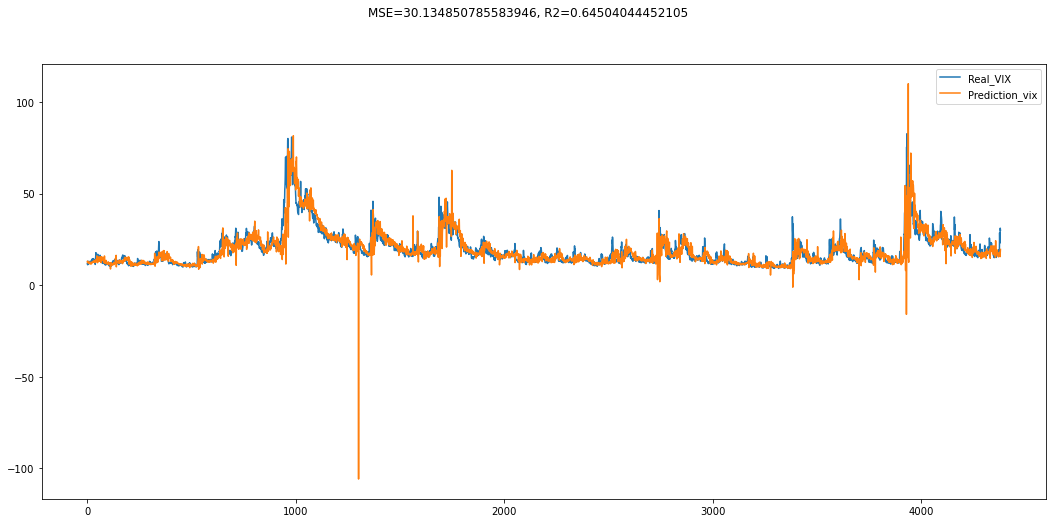

In [ ]:
# Mean Squared Error
print("Mean squared error: %.2f" % mean_squared_error(performance_frame['실제VIX'], performance_frame['예측vix']))

# r2_score
print("Coefficient of determination: %.2f" % r2_score(performance_frame['실제VIX'], performance_frame['예측vix']))
# error 높고, R2 낮음 그렇지만 어느정도 팔로윙하는모습 => 변동성 낮을때는 덜 민감하다가, 변동성이 높은 구간엔 훨씬 많이 민감해짐
def performance_graph(df):

    fig = plt.figure(figsize=(18, 8))

    plt.suptitle(
        f"MSE={mean_squared_error(df['실제VIX'], df['예측vix'])}, R2={r2_score(df['실제VIX'], df['예측vix'])}")

    ax = fig.add_subplot(1, 1, 1)
    ax.plot(df.index, df['실제VIX'], label='Real_VIX')
    ax.plot(df.index, df['예측vix'], label='Prediction_vix')
    plt.legend()

performance_graph(df=performance_frame)